# Projet RCP 209 : prédiction de rendement de stock

## Import library

In [264]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, multiply
from keras.models import Sequential
from keras.optimizers import SGD, Adamax
from keras.initializers import glorot_uniform, glorot_normal
import keras.backend as K
from keras.utils import np_utils

# Accuracy function

In [173]:
def CFM_metrics(y_true, y_pred):
    """
    Return the metrics used for the CFM Data Challenge 2019.

    This metrics is simply the accuracy of the prediction of positive returns
    (see below for details), but based on true *returns* (y_true) and
    probabilities (of returns being positive).

    Args
        y_true: Pandas Dataframe
            target returns. Positive returns will give True, and negative ones False.

        y_pred: Pandas Dataframe
            predicted probability of positive returns.

    """
    return ((y_true.values > 0) == (y_pred.values > 0.5)).mean()

# Get data

In [175]:
data_test = pd.read_csv("data_stock\\test_input.csv", sep=',')
data_train = pd.read_csv("data_stock\\training_input.csv", sep=',')
output_train = pd.read_csv("data_stock\\training_output.csv", sep=',')

# Premiere analyse

In [176]:
data_train.shape, data_test.shape, output_train.shape

((745327, 74), (319769, 74), (745327, 2))

In [177]:
data_train[["eqt_code","date"]].nunique()

eqt_code     680
date        1511
dtype: int64

In [178]:
nb_donnee = data_train.iloc[:,3:].size
nb_nan = data_train.iloc[:,3:].isna().sum().sum()
print("nb de données : ", nb_donnee, " nb données manquantes : ", nb_nan, "pourcentage données manquentes : ",round(nb_nan/nb_donnee * 100,4),"%")

nb de données :  52918217  nb données manquantes :  347646 pourcentage données manquentes :  0.6569 %


## Interpolation des valeurs Nan

In [179]:
#we linearly interpolate the NaN for the volatility and extrapolate to 0 
data_train.iloc[:,3:57] = data_train.iloc[:,3:].interpolate(axis=1)
data_test.iloc[:,3:57]  = data_test.iloc[:,3:].interpolate(axis=1)
#we use a flat extrapolation
data_train.fillna(0,inplace=True)
data_test.fillna(0,inplace=True)

In [180]:
#drop not necessary data
data_train_clean = data_train.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
data_test_clean = data_test.drop(['ID', 'eqt_code', 'date'], axis=1, inplace=False)
output_val_train = output_train["end_of_day_return"].values
X_train,X_test,y_train,y_test = train_test_split(data_train_clean,output_val_train,test_size=.2)

# Statitistique

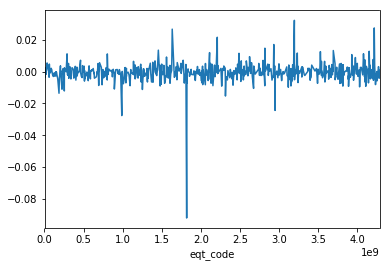

In [279]:
equity_mean = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).mean().mean(axis=1)
equity_median = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).median().median(axis=1)
equity_std = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).std().std(axis=1)
equity_hurtosis = data_train.drop(["date","ID"],axis=1).groupby(["eqt_code"]).apply(pd.DataFrame.kurtosis)
equity_mean.plot()

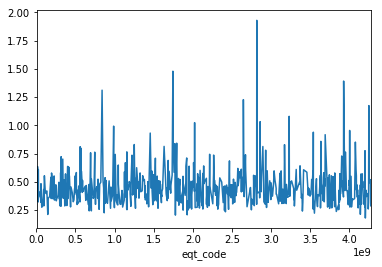

In [280]:
equity_std.plot()

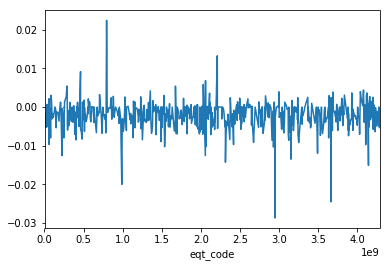

In [281]:
equity_median.plot()

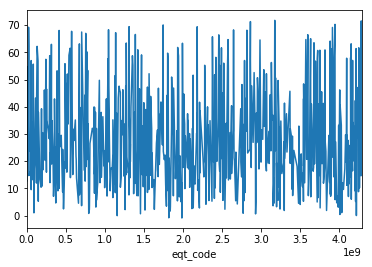

In [282]:
equity_hurtosis.T.apply(pd.DataFrame.kurtosis).plot()

In [283]:
stat = pd.DataFrame()
stat["equity mean"] = equity_mean.describe()
stat["equity median"] = equity_median.describe()
stat["equity std"] = equity_std.describe()
stat["equity kurtosis"] = equity_hurtosis.T.apply(pd.DataFrame.kurtosis).describe()
stat

,equity mean,equity median,equity std,equity kurtosis
count,680.000000,680.000000,680.000000,680.000000
mean,-0.000536,-0.002059,0.449859,27.885478
std,0.005871,0.003439,0.164241,17.648373
min,-0.091875,-0.028685,0.180033,-0.881237
25%,-0.002640,-0.003468,0.351263,14.385478
50%,-0.000398,-0.001725,0.422859,24.032289
75%,0.001794,0.000000,0.508102,38.139064
max,0.032099,0.022428,1.930473,71.750920


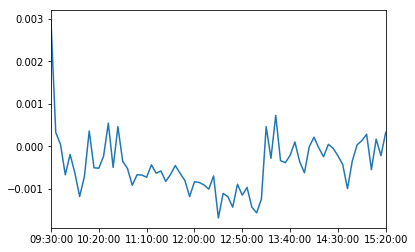

In [286]:
equity_date_mean = data_train.drop(["eqt_code","ID"],axis=1).groupby(["date"]).mean().mean(axis=0)
equity_date_median = data_train.drop(["eqt_code","ID"],axis=1).groupby(["date"]).median().median(axis=0)
equity_date_std = data_train.drop(["eqt_code","ID"],axis=1).groupby(["date"]).std().std(axis=0)
equity_date_hurtosis = data_train.drop(["eqt_code","ID"],axis=1).groupby(["date"]).apply(pd.DataFrame.kurtosis)
equity_date_mean.plot()


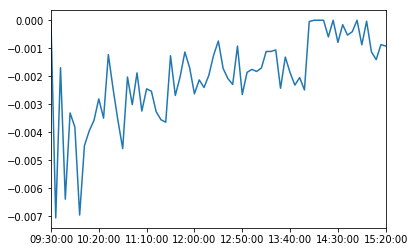

In [287]:
equity_date_median.plot()

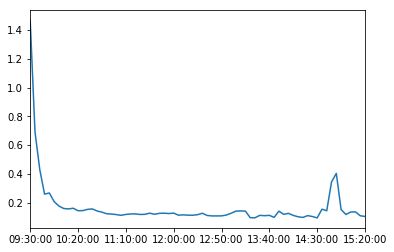

In [289]:
equity_date_std.plot()

# Linear regression

In [197]:
def trainData(model,train_set=X_train,test_set=X_test,output_train=y_train,output_test=y_test,test=data_test_clean):
    print("we train")
    model.fit(train_set,output_train)
    print("training done, we start the prediction")
    y_pred = model.predict(train_set)
    y_pred_proba = [1 if row >0 else 0 for row in y_pred ]
    y_pred_test = model.predict(test_set)
    y_pred_test_proba = [1 if row >0 else 0 for row in y_pred_test ]
    print('Train error =', round(CFM_metrics(pd.DataFrame(data=y_pred_proba), pd.DataFrame(data=output_train)), 4), '%')
    print('Test error =', round(CFM_metrics(pd.DataFrame(data=y_pred_test_proba), pd.DataFrame(data=output_test)), 4), '%')
    print("we return the test prediction")
    tmp = model.predict(test)
    tmp = [1 if row>0 else 0 for row in tmp]
    return tmp

def sendPredictionToCfmFormat(prediction, test = data_test, fileName = 'predictions'):
    output = pd.DataFrame()
    output["ID"] = test["ID"]
    output["end_of_day_return"] = prediction
    output.to_csv(fileName+'.csv', sep=',', index=False)
    print("prediction send to"+fileName+'.csv')


In [198]:
regrLinWeighted = LinearRegression()
y_pred_linearReg = trainData(regrLinWeighted)

we train
training done, we start the prediction
Train error = 0.5141 %
Test error = 0.5129 %
we return the test prediction


In [199]:
sendPredictionToCfmFormat(y_pred_linearReg,fileName='predictionLinReg')

prediction send topredictionLinReg.csv


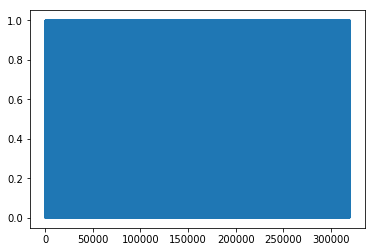

In [200]:
plt.plot(y_pred_linearReg)

## Regression with regularization : Lasso

In [201]:
lasso = Lasso(alpha=.5)
y_pred_linearRegLasso = trainData(lasso)

we train
training done, we start the prediction
Train error = 0.2611 %
Test error = 0.2604 %
we return the test prediction


In [202]:
sendPredictionToCfmFormat(y_pred_linearRegLasso,fileName='predictionLinLasso')

prediction send topredictionLinLasso.csv


## Regression with regularisation : Ridge

In [203]:
ridge = Ridge(alpha=2.0)
y_pred_linearRegRidge = trainData(ridge)

we train
training done, we start the prediction
Train error = 0.5141 %
Test error = 0.5129 %
we return the test prediction


In [204]:
sendPredictionToCfmFormat(y_pred_linearRegRidge,fileName='predictionLinRidge')

prediction send topredictionLinRidge.csv


# Logistic regression

In [206]:
output_logistic= pd.DataFrame()
output_logistic["ID"] = output_train["ID"]
output_logistic["end_of_day_return"] = output_train["end_of_day_return"].apply(lambda row : 1 if row > 0 else 0)
output_log = output_logistic["end_of_day_return"].values
X_train,X_test,y_train,y_test = train_test_split(data_train_clean,output_log,test_size=.2)

In [214]:
logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train,y_train)
print("train score : ",logistic.score(X_train,y_train))
print("test score : ",logistic.score(X_test,y_test))
y_pred_logistic = logistic.predict_proba(data_test_clean)
logistic.score(data_train_clean,output_log)

train score :  0.5215970858399258
test score :  0.5201454389330901


0.52130675528996

In [215]:
sendPredictionToCfmFormat(y_pred_logistic[:,1],fileName='predictionLogistic')

prediction send topredictionLogistic.csv


# Logistic regression with Cross validation

In [221]:
logistic = LogisticRegressionCV(solver='lbfgs',Cs=[.01,.1,1,2,5,10,100],cv=5,verbose=1)
logistic.fit(X_train,y_train)
print("train score : ",logistic.score(X_train,y_train))
print("test score : ",logistic.score(X_test,y_test))
y_pred_logisticCV = logistic.predict_proba(data_test_clean)
logistic.score(data_train_clean,output_log)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   14.5s finished


train score :  0.5215853460145808
test score :  0.5200850629922317


0.5212852882023595

In [223]:
print(logistic.C_)
sendPredictionToCfmFormat(y_pred_logistic[:,1],fileName='predictionLogisticCV')

[0.1]
prediction send topredictionLogisticCV.csv


# SVM

## Linear

In [224]:
svc = LinearSVC(tol=1.e-3,verbose=1)
svc.fit(X_train,y_train)
print("train score : ",svc.score(X_train,y_train))
print("test score : ",svc.score(X_test,y_test))
y_pred_svc = svc.predict_proba(data_test_clean)
svc.score(data_train_clean,output_log)

[LibLinear]train score :  0.5222494847055232
test score :  0.5199576026726417


C:\Users\jerom\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [226]:
sendPredictionToCfmFormat(y_pred_svc,fileName='predictionSVC')

NameError: name 'y_pred_svc' is not defined

# Logistic regress with loss function : CMF

In [319]:
Y_train = np_utils.to_categorical(y_train,2 )
Y_test = np_utils.to_categorical(y_test,2 )
model = Sequential()
model.add(Dense(X_train.shape[1],  input_dim=X_train.shape[1], name='fc1',kernel_initializer=glorot_normal()))
model.add(Activation('tanh'))
model.add(Dense(2,name='fc2',activation='softmax'))
adam = Adamax()
model.compile(loss="categorical_crossentropy",optimizer='rmsprop',metrics=["binary_accuracy"])
batch_size=500
n_epoch=20
model.fit(X_train,Y_train,epochs=n_epoch,batch_size=batch_size,verbose=1)

Epoch 1/20
596261/596261 [==============================] - 4s 7us/step - loss: 0.6953 - binary_accuracy: 0.5139
Epoch 2/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6927 - binary_accuracy: 0.5177
Epoch 3/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6922 - binary_accuracy: 0.5193
Epoch 4/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6920 - binary_accuracy: 0.5207
Epoch 5/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6919 - binary_accuracy: 0.5214
Epoch 6/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6919 - binary_accuracy: 0.5214
Epoch 7/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6918 - binary_accuracy: 0.5221
Epoch 8/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6917 - binary_accuracy: 0.5216
Epoch 9/20
596261/596261 [==============================] - 3s 6us/step - loss: 0.6916 - binary_

In [320]:
print(model.evaluate(X_train,Y_train,verbose=1))
print(model.evaluate(X_test,Y_test,verbose=1))

596261/596261 [==============================] - 13s 22us/step
[0.6890742437319987, 0.5337981186092325]
149066/149066 [==============================] - 4s 24us/step
[0.6942616479415021, 0.5131149960424215]


In [321]:
y_pred = model.predict_proba(data_train_clean)
CFM_metrics(pd.DataFrame(output_train["end_of_day_return"].values),pd.DataFrame(y_pred[:,1]))

0.5296614774454702

In [322]:
test_pred =  model.predict_proba(data_test_clean)
sendPredictionToCfmFormat(test_pred[:,1],fileName='NN')

prediction send toNN.csv


In [318]:
test_pred

array([[0.44033068, 0.5596693 ],
       [0.44104674, 0.5589532 ],
       [0.52120835, 0.4787916 ],
       ...,
       [0.5627397 , 0.4372603 ],
       [0.49365795, 0.50634205],
       [0.46194956, 0.5380505 ]], dtype=float32)